/opt/homebrew/Caskroom/miniconda/base/envs/qiskit/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


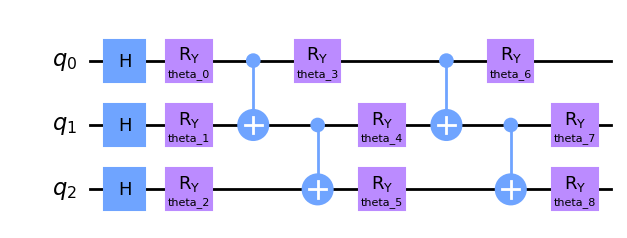

In [1]:
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import QuantumCircuit, Parameter

qr = QuantumRegister(3, 'q')
qc = QuantumCircuit(qr)

angles = [Parameter(f"theta_{i}") for i in range(9)]

# Layer 0
qc.h(qr[0:3])
qc.ry(angles[0], qr[0])
qc.ry(angles[1], qr[1])
qc.ry(angles[2], qr[2])

# Layer 1

qc.cx(qr[0], qr[1])
qc.ry(angles[3], qr[0])
qc.cx(qr[1], qr[2])
qc.ry(angles[4], qr[1])
qc.ry(angles[5], qr[2])

# Layer 2
qc.cx(qr[0], qr[1])
qc.ry(angles[6], qr[0])
qc.cx(qr[1], qr[2])
qc.ry(angles[7], qr[1])
qc.ry(angles[8], qr[2])

qc.draw('mpl')

In [2]:
# Why we design the circuit in this way?

# superposition + parameter ?

# How to back propagate the parameter?

# How to use the quantum feature to detect the minimum of the function?

# 哥德尔编码